In [118]:
import os 
import cv2
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [119]:
down_images = len(os.listdir(os.path.join('images','down')))
up_flipped = len(os.listdir(os.path.join('images','flip_up')))

min_images = down_images +up_flipped
print(min_images)

nothing = len(os.listdir(os.path.join('images','nothing')))
print(nothing)

469
584


In [120]:
images = []
labels = []

img_height, img_width = 96,96
classes = ["up", "down", "left", "right", "nothing"]

num_of_images = [0,0,0,0,0]


down_images = len(os.listdir(os.path.join('images','down')))
up_flipped = len(os.listdir(os.path.join('images','flip_up')))

min_images = down_images +up_flipped


for i in range(len(classes)):
    a_class = classes[i]
    folder_path = os.path.join('images',a_class) # grab each folder
    print(folder_path)
    counter = 0
    for image in os.listdir(folder_path):
        if counter == min_images:
            print("Reached enough images")
            break
        img_path = os.path.join(folder_path,image) # grab each image
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert from BGR format to RGB
            img = cv2.resize(img, (img_width,img_height))
            img = img /255.0
            
            images.append(img)
            labels.append(a_class)
            counter += 1
        
    print(f"Number of images {counter}")
    num_of_images[i] = counter
    print(num_of_images)

    
print(f"Total images loaded: {len(images)}")
print(f"Images per class: {num_of_images}")

dict_no_of_images = dict(zip(classes, num_of_images))

images\up
Number of images 316
[316, 0, 0, 0, 0]
images\down
Number of images 181
[316, 181, 0, 0, 0]
images\left
Number of images 348
[316, 181, 348, 0, 0]
images\right
Number of images 369
[316, 181, 348, 369, 0]
images\nothing
Reached enough images
Number of images 469
[316, 181, 348, 369, 469]
Total images loaded: 1683
Images per class: [316, 181, 348, 369, 469]


In [121]:
## inserting flipped images
flip_folders = {
    'flip_up': 'down',      
    'flip_down': 'up',
    'flip_left': 'right',      
    'flip_right': 'left',
}



for flip_folder, target_label in flip_folders.items():
    folder_path = os.path.join('images', flip_folder)
    image_counter = dict_no_of_images[target_label]
    
    if os.path.exists(folder_path):
        counter = image_counter
        
        for image in os.listdir(folder_path):
            if counter == min_images:
                print("Reached enough flipped images")
                break
                
            img_path = os.path.join(folder_path, image)
            img = cv2.imread(img_path)
            
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (img_width, img_height))
                img = img / 255.0
                
                images.append(img)
                labels.append(target_label)
                counter += 1
        
        # Update num_of_images for the target class
        target_class_index = classes.index(target_label)
        dict_no_of_images[target_label] = counter
        
        print(f"Added {counter} flipped images from '{flip_folder}' labeled as '{target_label}'")



print(f"Total Amount of images {dict_no_of_images}")
print('["up", "down", "left", "right", "nothing"]')




Added 469 flipped images from 'flip_up' labeled as 'down'
Reached enough flipped images
Added 469 flipped images from 'flip_down' labeled as 'up'
Reached enough flipped images
Added 469 flipped images from 'flip_left' labeled as 'right'
Reached enough flipped images
Added 469 flipped images from 'flip_right' labeled as 'left'
Total Amount of images {'up': 469, 'down': 469, 'left': 469, 'right': 469, 'nothing': 469}
["up", "down", "left", "right", "nothing"]


In [122]:
X = np.array(images)
y = np.array(labels)

# one hot encode the labels
classes_to_index = {cls:idx for idx,cls in enumerate(classes)} # index: label for enum

# fill up with 0s, for each example, 
y_onehot = np.zeros((len(y), len(classes))) #number of examples, number of classes
for i, label in enumerate(y):
    y_onehot[i, classes_to_index[label]] = 1 # first dimension: rows, second: column

print(y_onehot.shape)
print(y_onehot[:-5])

(2345, 5)
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [123]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, test_size=0.2, random_state=42, stratify= y)


print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


Training set: (1876, 96, 96, 3), (1876, 5)
Test set: (469, 96, 96, 3), (469, 5)


In [ ]:
from tensorflow import keras
from keras import layers

# fml i think its overfitting so badly time to play more subway surfers 
## TODO: flip image to augment dataset
model = keras.Sequential()

# convolution layer
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(img_height, img_width, 3)))

# pooling layer
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Flatten())

## trad nn
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3)) # trying to reduce overfitting
model.add(layers.Dense(5, activation="linear"))  # 5 classes

# categorical crossentropy 
# from_logits already applied softmax internally 
model.compile(
	loss=keras.losses.CategoricalCrossentropy(from_logits=True),
	optimizer='adam',
	metrics=['accuracy']
)

# fit the model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.2841 - loss: 1.5536 - val_accuracy: 0.3817 - val_loss: 1.3705
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.5101 - loss: 1.1576 - val_accuracy: 0.5842 - val_loss: 0.9714
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.6354 - loss: 0.8865 - val_accuracy: 0.6119 - val_loss: 0.8737
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.6914 - loss: 0.7776 - val_accuracy: 0.6397 - val_loss: 0.8088
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.7511 - loss: 0.6009 - val_accuracy: 0.6780 - val_loss: 0.7552
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.8204 - loss: 0.4833 - val_accuracy: 0.7207 - val_loss: 0.7487
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.8449 - loss: 0.4233 - val_accuracy: 0.7249 - val_loss: 0.7249
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.8689 - loss: 0.3424 - val_accuracy: 0.7122 - 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Number of wrong predictions: 119 out of 469


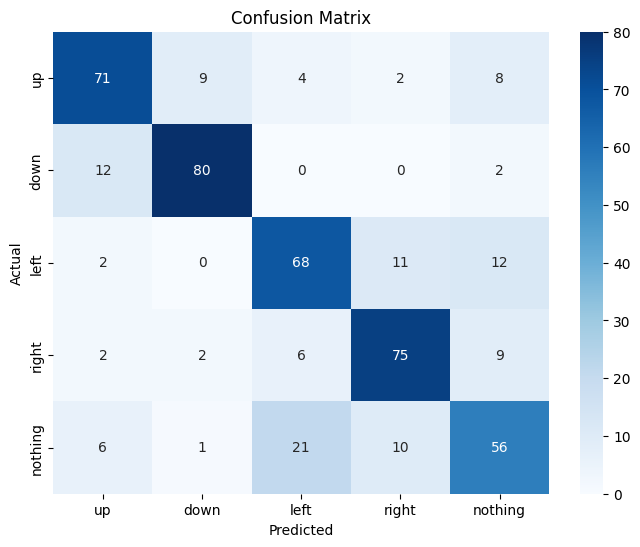


Classification Report:
              precision    recall  f1-score   support

          up       0.76      0.76      0.76        94
        down       0.87      0.85      0.86        94
        left       0.69      0.73      0.71        93
       right       0.77      0.80      0.78        94
     nothing       0.64      0.60      0.62        94

    accuracy                           0.75       469
   macro avg       0.75      0.75      0.75       469
weighted avg       0.75      0.75      0.75       469



In [128]:


# check whihch one wrong
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  
y_true_classes = np.argmax(y_test, axis=1) 

# Find incorrectly predicted samples
wrong_indices = np.where(y_pred_classes != y_true_classes)[0]
print(f"Number of wrong predictions: {len(wrong_indices)} out of {len(y_test)}")

# Create confusion matrix to see patterns in mistakes
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, 
                          target_names=classes))



74.6 Accuracy Rate
Up / Down Confusion:
- some obstacles have two ways of getting by it, and in my gameplay i used both ways so some labels might have been inaccurate

Left and nothing (and right) seems to be mixed up more often
- Apply a higher threshold for left and right actions when using the model for predictions

In [132]:
# Analyze wrong predictions in detail
import matplotlib.pyplot as plt

# Create reverse mapping from index to class name
index_to_class = {idx: cls for cls, idx in classes_to_index.items()}

print("Wrong predictions analysis:")
for i in wrong_indices:  # Show wrong predictions
    true_class = index_to_class[y_true_classes[i]]
    pred_class = index_to_class[y_pred_classes[i]]
    
    confidence = np.max(y_pred[i]) * 100
    
    print(f"Index {i}: True={true_class}, Predicted={pred_class}, Confidence={confidence:.1f}%")

Wrong predictions analysis:
Index 7: True=nothing, Predicted=left, Confidence=521.5%
Index 10: True=up, Predicted=down, Confidence=787.1%
Index 12: True=nothing, Predicted=left, Confidence=502.3%
Index 14: True=nothing, Predicted=left, Confidence=536.2%
Index 15: True=left, Predicted=nothing, Confidence=438.6%
Index 16: True=right, Predicted=down, Confidence=167.0%
Index 18: True=left, Predicted=right, Confidence=837.0%
Index 21: True=nothing, Predicted=right, Confidence=712.0%
Index 25: True=right, Predicted=left, Confidence=870.0%
Index 38: True=left, Predicted=up, Confidence=579.0%
Index 41: True=left, Predicted=right, Confidence=696.0%
Index 50: True=down, Predicted=up, Confidence=808.4%
Index 51: True=nothing, Predicted=left, Confidence=810.9%
Index 53: True=up, Predicted=down, Confidence=628.8%
Index 55: True=up, Predicted=left, Confidence=644.9%
Index 61: True=up, Predicted=nothing, Confidence=304.2%
Index 64: True=right, Predicted=up, Confidence=264.9%
Index 66: True=left, Pred

In [ ]:
# Save wrong predictions for manual review
def save_wrong_predictions():
    import os
    
    # Create directory for wrong predictions
    os.makedirs('wrong_predictions', exist_ok=True)
    
    for i, idx in enumerate(wrong_indices[:30]):  # Save first 30
        true_class = index_to_class[y_true_classes[idx]]
        pred_class = index_to_class[y_pred_classes[idx]]
        confidence = np.max(y_pred[idx]) * 100
        
        # Convert image back to 0-255 
        img_to_save = (X_test[idx] * 255).astype(np.uint8)
        
        filename = f"wrong_{i:03d}_true_{true_class}_pred_{pred_class}_conf_{confidence:.0f}.png"
        filepath = os.path.join('wrong_predictions', filename)
        
        plt.imsave(filepath, img_to_save)
    
    print(f"Saved to 'wrong_predictions' folder")

save_wrong_predictions()


Saved 20 wrong predictions to 'wrong_predictions' folder


In [133]:
## save the model
model.save("model/model_1.keras")